# Returns vs Log-Price (+ Earnings) backtests (Chronos-2)

**Goal.** Compare two target formulations under the same backtest protocol:
- **Returns target** (log-returns)
- **Log-price target** (log(price)) with **earnings-window** as a known-future covariate

We focus on:
1. **Mean metrics** (MAE, Pinball)
2. **Paired deltas vs baseline** (variant - baseline) per cutoff
3. **Bootstrap CIs** on mean deltas (paired by cutoff)
4. **Paired scatter** baseline vs variant (visual dominance test)


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Paths + loading
This cell is intentionally robust to running the notebook either from the project root or from `notebooks/`.


In [12]:
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

RET_PATH  = PROJECT_ROOT / "data/processed/e1_returns_ctx256_step10_cut15.parquet"
LOGP_PATH = PROJECT_ROOT / "data/processed/e1_logprice_earn_ctx256_step10_cut15.parquet"

print("CWD:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("RET exists:",  RET_PATH.exists(),  RET_PATH)
print("LOGP exists:", LOGP_PATH.exists(), LOGP_PATH)

ret  = pd.read_parquet(RET_PATH)
logp = pd.read_parquet(LOGP_PATH)

# tag
ret  = ret.copy()
logp = logp.copy()
ret["dataset"]  = "returns"
logp["dataset"] = "log_price+earn"
ret["cutoff"]  = pd.to_datetime(ret["cutoff"])
logp["cutoff"] = pd.to_datetime(logp["cutoff"])

print("returns:", ret.shape, "| columns:", ret.columns.tolist())
print("logp+earn:", logp.shape, "| columns:", logp.columns.tolist())

display(ret.head(3))
display(logp.head(3))


CWD: /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/notebooks
PROJECT_ROOT: /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension
RET exists: True /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/e1_returns_ctx256_step10_cut15.parquet
LOGP exists: True /Users/mattiahsbubich/Desktop/polito/ANNO 2/deep natural language processing/extension/data/processed/e1_logprice_earn_ctx256_step10_cut15.parquet
returns: (180, 7) | columns: ['cutoff', 'horizon', 'variant', 'mae', 'pinball', 'n_points', 'dataset']
logp+earn: (180, 7) | columns: ['cutoff', 'horizon', 'variant', 'mae', 'pinball', 'n_points', 'dataset']


,cutoff,horizon,variant,mae,pinball,n_points,dataset
0,2025-05-12,1,baseline,0.018606,0.006561,61,returns
1,2025-05-12,1,past_only,0.018978,0.006528,61,returns
2,2025-05-12,1,past_plus_known_future,0.019447,0.006654,61,returns


,cutoff,horizon,variant,mae,pinball,n_points,dataset
0,2025-05-12,1,baseline,0.018860,0.006573,117,log_price+earn
1,2025-05-12,1,past_only,0.020229,0.006741,117,log_price+earn
2,2025-05-12,1,past_plus_known_future,0.020180,0.006765,117,log_price+earn


## Helper functions


In [13]:
def mean_table(df: pd.DataFrame) -> pd.DataFrame:
    out = (
        df.groupby(["dataset", "horizon", "variant"], as_index=False)
          .agg(mae=("mae", "mean"),
               pinball=("pinball", "mean"),
               n_points=("n_points", "mean"))
    )
    return out.sort_values(["dataset", "horizon", "mae"])

def deltas_vs_baseline(df_mean: pd.DataFrame) -> pd.DataFrame:
    base = (
        df_mean[df_mean["variant"] == "baseline"][["dataset", "horizon", "mae", "pinball"]]
        .rename(columns={"mae": "mae_base", "pinball": "pin_base"})
    )
    m = df_mean.merge(base, on=["dataset", "horizon"], how="left")
    m["d_mae"] = m["mae"] - m["mae_base"]
    m["d_pin"] = m["pinball"] - m["pin_base"]
    m["d_mae_pct"] = 100 * m["d_mae"] / m["mae_base"]
    m["d_pin_pct"] = 100 * m["d_pin"] / m["pin_base"]
    return m.sort_values(["dataset", "horizon", "d_mae"])

def pivot_by_cutoff(df: pd.DataFrame, horizon: int, metric: str) -> pd.DataFrame:
    d = df[df["horizon"] == horizon].copy()
    wide = d.pivot_table(index="cutoff", columns="variant", values=metric, aggfunc="mean").dropna()
    return wide

def paired_bootstrap_ci(df: pd.DataFrame, horizon: int, variant: str, metric: str = "mae",
                        n_boot: int = 2000, seed: int = 0):
    """Bootstrap CI on mean delta (variant - baseline), paired by cutoff."""
    wide = pivot_by_cutoff(df, horizon=horizon, metric=metric)
    if "baseline" not in wide.columns or variant not in wide.columns:
        return None
    delta = (wide[variant] - wide["baseline"]).to_numpy()
    if len(delta) < 5:
        return None

    rng = np.random.default_rng(seed)
    boot_means = []
    n = len(delta)
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        boot_means.append(delta[idx].mean())

    lo, hi = np.quantile(boot_means, [0.025, 0.975])
    return float(delta.mean()), float(lo), float(hi), int(n)

def forest_plot(df: pd.DataFrame, title: str, metric: str = "mae",
                variants=("calendar_only", "past_only", "past_plus_known_future"),
                horizons=(1, 5, 20), n_boot=2000, seed=0):
    rows = []
    for h in horizons:
        for v in variants:
            res = paired_bootstrap_ci(df, horizon=h, variant=v, metric=metric, n_boot=n_boot, seed=seed)
            if res is None:
                continue
            mean_d, lo, hi, n = res
            rows.append({"horizon": h, "variant": v, "mean": mean_d, "lo": lo, "hi": hi, "n_cutoffs": n})
    ci = pd.DataFrame(rows)
    if ci.empty:
        print("No CI rows to plot.")
        return ci

    ci["label"] = ci.apply(lambda r: f"H={int(r['horizon'])}  {r['variant']}", axis=1)
    y = np.arange(len(ci))[::-1]

    fig, ax = plt.subplots(figsize=(9, 0.35 * len(ci) + 1.5))
    ax.errorbar(
        x=ci["mean"], y=y,
        xerr=[ci["mean"] - ci["lo"], ci["hi"] - ci["mean"]],
        fmt="o", capsize=3
    )
    ax.axvline(0.0, linewidth=1)
    ax.set_yticks(y)
    ax.set_yticklabels(ci["label"])
    ax.set_xlabel(f"Δ{metric} vs baseline (variant - baseline)  ↓ better")
    ax.set_title(title)
    ax.grid(True, axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()
    return ci

def paired_scatter(df: pd.DataFrame, title: str, metric: str = "mae", horizon: int = 20,
                   variant: str = "calendar_only"):
    wide = pivot_by_cutoff(df, horizon=horizon, metric=metric)
    if "baseline" not in wide.columns or variant not in wide.columns:
        print("Missing columns for scatter.")
        return

    x = wide["baseline"].to_numpy()
    y = wide[variant].to_numpy()

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x, y, alpha=0.8)
    mn = min(x.min(), y.min())
    mx = max(x.max(), y.max())
    ax.plot([mn, mx], [mn, mx], linewidth=1)  # y = x
    ax.set_xlabel(f"Baseline {metric} (H={horizon})")
    ax.set_ylabel(f"{variant} {metric} (H={horizon})")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def boxplot_deltas(df: pd.DataFrame, title: str, horizon: int = 20, metric: str = "mae",
                   variants=("calendar_only", "past_plus_known_future", "past_only")):
    # compute per-cutoff delta vs baseline, then boxplot deltas for variants
    wide = pivot_by_cutoff(df, horizon=horizon, metric=metric)
    if "baseline" not in wide.columns:
        print("Missing baseline for boxplot.")
        return
    deltas = {v: (wide[v] - wide["baseline"]).dropna().to_numpy() for v in variants if v in wide.columns}
    data = [deltas[v] for v in variants if v in deltas]
    labels = [v for v in variants if v in deltas]

    plt.figure(figsize=(7, 4))
    plt.boxplot(data, tick_labels=labels, showfliers=False)  # tick_labels avoids Matplotlib deprecation
    plt.axhline(0.0, linewidth=1)
    plt.ylabel(f"Δ{metric} vs baseline")
    plt.title(title)
    plt.tight_layout()
    plt.show()


## Mean metrics (side-by-side)


In [14]:
df_all = pd.concat([ret, logp], ignore_index=True)
df_mean = mean_table(df_all)
display(df_mean)


,dataset,horizon,variant,mae,pinball,n_points
1,log_price+earn,1,calendar_only,0.014245,0.004756,117.000000
0,log_price+earn,1,baseline,0.014293,0.004807,117.000000
3,log_price+earn,1,past_plus_known_future,0.014733,0.004891,117.000000
2,log_price+earn,1,past_only,0.014934,0.004961,117.000000
5,log_price+earn,5,calendar_only,0.022607,0.007494,577.200000
4,log_price+earn,5,baseline,0.023137,0.007735,577.200000
7,log_price+earn,5,past_plus_known_future,0.023788,0.007801,577.200000
6,log_price+earn,5,past_only,0.023971,0.007872,577.200000
9,log_price+earn,20,calendar_only,0.038978,0.012821,2269.800000
8,log_price+earn,20,baseline,0.041662,0.013803,2269.800000


## Deltas vs baseline (mean level)


In [22]:
df_delta = deltas_vs_baseline(df_mean)
display(df_delta)


,dataset,horizon,variant,mae,pinball,n_points,mae_base,pin_base,d_mae,d_pin,d_mae_pct,d_pin_pct
0,log_price+earn,1,calendar_only,0.014245,0.004756,117.000000,0.014293,0.004807,-0.000048,-5.035334e-05,-0.335424,-1.047593
1,log_price+earn,1,baseline,0.014293,0.004807,117.000000,0.014293,0.004807,0.000000,0.000000e+00,0.000000,0.000000
2,log_price+earn,1,past_plus_known_future,0.014733,0.004891,117.000000,0.014293,0.004807,0.000440,8.427192e-05,3.078000,1.753263
3,log_price+earn,1,past_only,0.014934,0.004961,117.000000,0.014293,0.004807,0.000641,1.548799e-04,4.484037,3.222251
4,log_price+earn,5,calendar_only,0.022607,0.007494,577.200000,0.023137,0.007735,-0.000530,-2.413618e-04,-2.292413,-3.120323
5,log_price+earn,5,baseline,0.023137,0.007735,577.200000,0.023137,0.007735,0.000000,0.000000e+00,0.000000,0.000000
6,log_price+earn,5,past_plus_known_future,0.023788,0.007801,577.200000,0.023137,0.007735,0.000651,6.586214e-05,2.814393,0.851465
7,log_price+earn,5,past_only,0.023971,0.007872,577.200000,0.023137,0.007735,0.000834,1.366844e-04,3.604343,1.767055
8,log_price+earn,20,calendar_only,0.038978,0.012821,2269.800000,0.041662,0.013803,-0.002684,-9.819453e-04,-6.441851,-7.114052
9,log_price+earn,20,baseline,0.041662,0.013803,2269.800000,0.041662,0.013803,0.000000,0.000000e+00,0.000000,0.000000


## Forest plots: bootstrap CI of deltas vs baseline

Interpretation: points left of 0 mean **improvement** (lower metric) vs baseline.


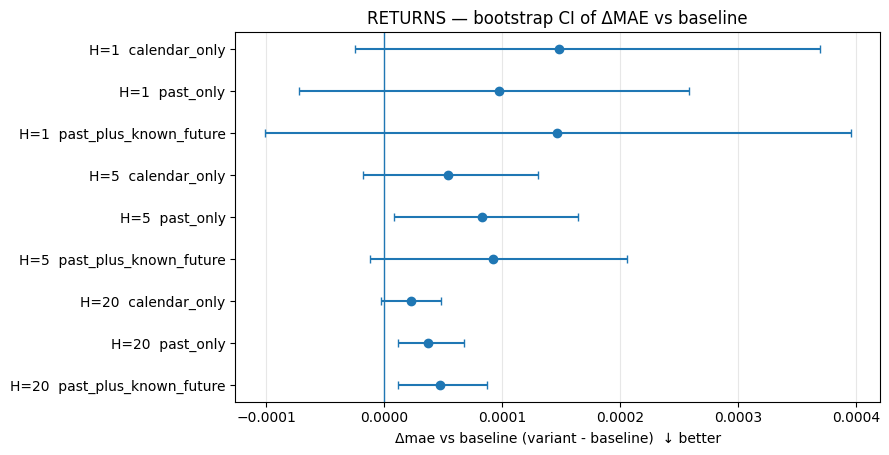

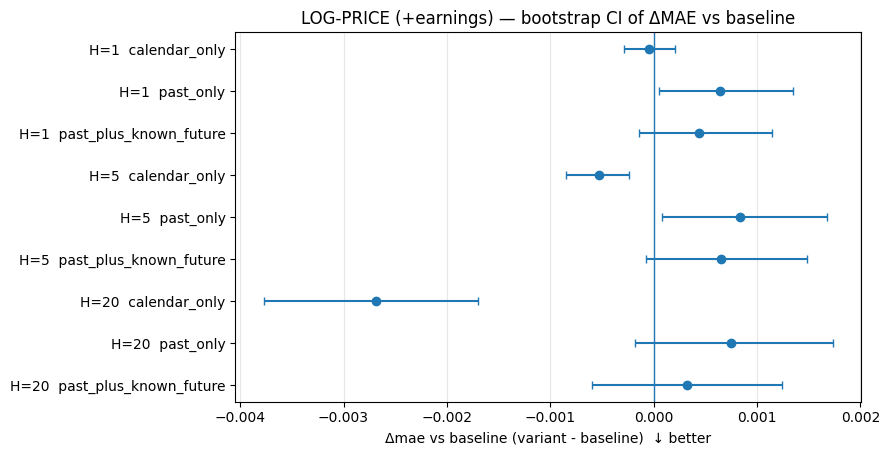

In [16]:
_ = forest_plot(ret,  title="RETURNS — bootstrap CI of ΔMAE vs baseline", metric="mae", n_boot=2000, seed=0)
_ = forest_plot(logp, title="LOG-PRICE (+earnings) — bootstrap CI of ΔMAE vs baseline", metric="mae", n_boot=2000, seed=0)


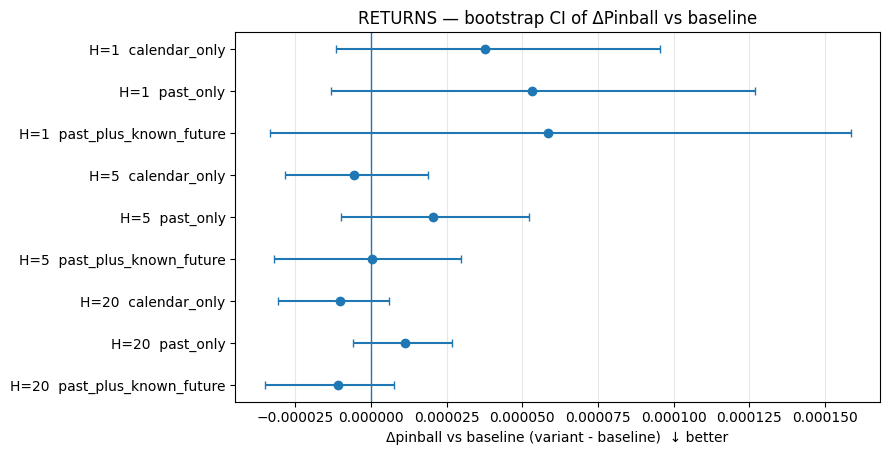

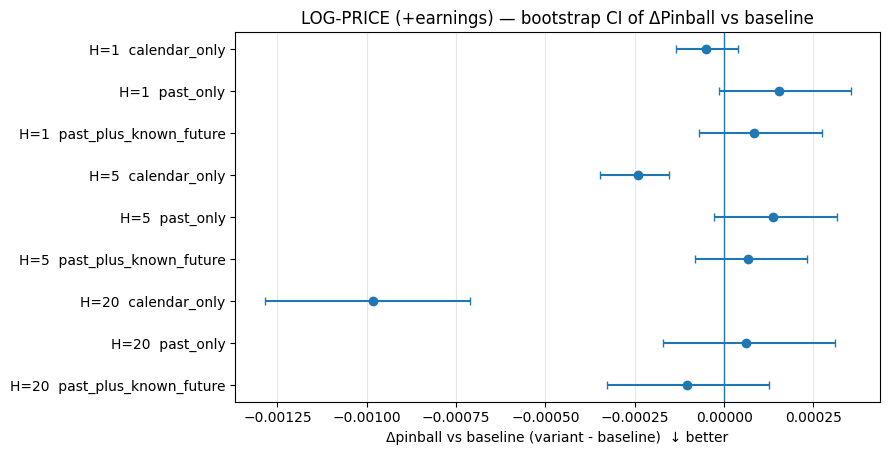

In [17]:
_ = forest_plot(ret,  title="RETURNS — bootstrap CI of ΔPinball vs baseline", metric="pinball", n_boot=2000, seed=0)
_ = forest_plot(logp, title="LOG-PRICE (+earnings) — bootstrap CI of ΔPinball vs baseline", metric="pinball", n_boot=2000, seed=0)


## Paired scatter at H=20 (baseline vs calendar_only)

If most points lie **below** the diagonal `y=x`, the variant dominates baseline for that horizon.


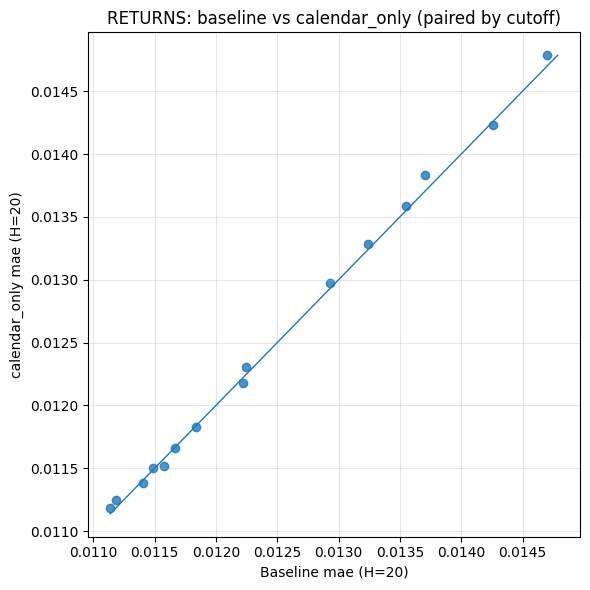

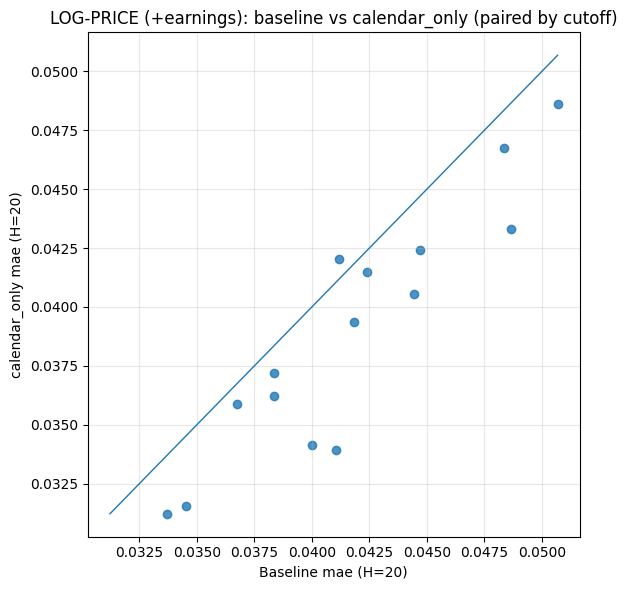

In [18]:
paired_scatter(ret,  title="RETURNS: baseline vs calendar_only (paired by cutoff)", metric="mae", horizon=20, variant="calendar_only")
paired_scatter(logp, title="LOG-PRICE (+earnings): baseline vs calendar_only (paired by cutoff)", metric="mae", horizon=20, variant="calendar_only")


## Distribution of deltas across cutoffs (boxplots)

This shows variability across cutoffs (robustness), not just the mean.


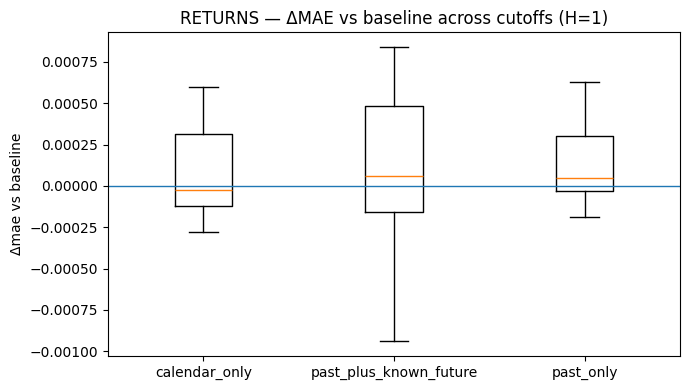

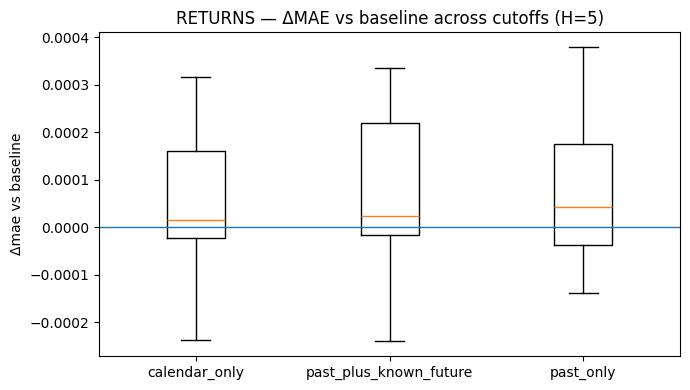

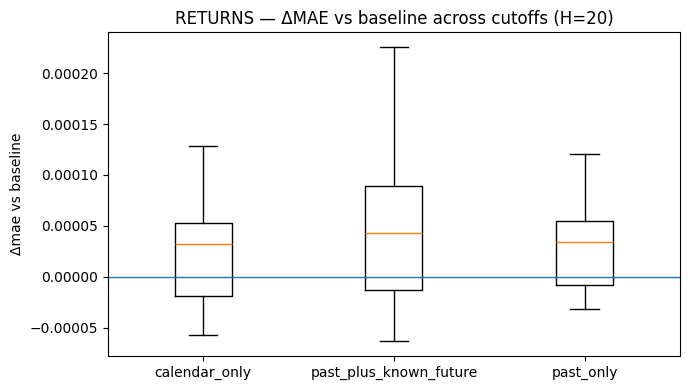

In [19]:
for h in [1, 5, 20]:
    boxplot_deltas(ret,  title=f"RETURNS — ΔMAE vs baseline across cutoffs (H={h})", horizon=h, metric="mae")


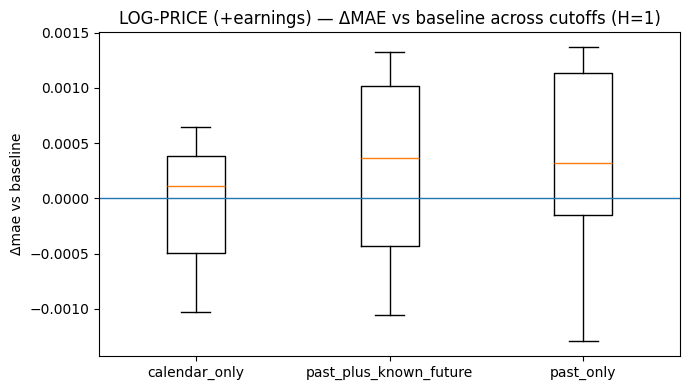

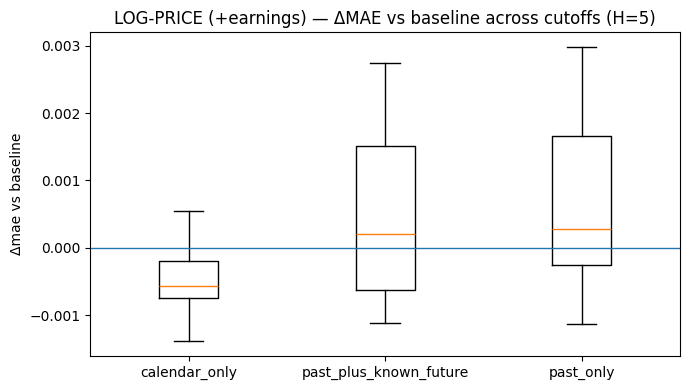

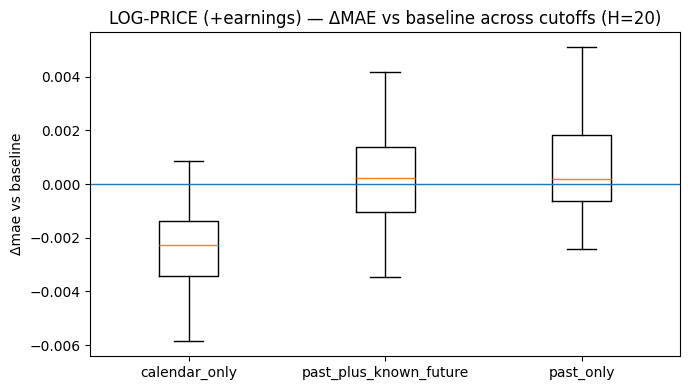

In [20]:
for h in [1, 5, 20]:
    boxplot_deltas(logp, title=f"LOG-PRICE (+earnings) — ΔMAE vs baseline across cutoffs (H={h})", horizon=h, metric="mae")


## A compact “best variant” summary

This is a coarse summary (only the mean), but useful as a headline.


In [21]:
def best_variant(df_mean_one: pd.DataFrame) -> pd.DataFrame:
    best = df_mean_one.sort_values("mae").groupby(["dataset", "horizon"]).head(1)
    return best[["dataset", "horizon", "variant", "mae", "pinball"]].reset_index(drop=True)

best = best_variant(df_mean)
display(best)

cmp = (best[best["dataset"]=="returns"]
       .rename(columns={"variant":"best_variant_returns", "mae":"mae_returns", "pinball":"pin_returns"})
       .merge(best[best["dataset"]=="log_price+earn"]
              .rename(columns={"variant":"best_variant_logp", "mae":"mae_logp", "pinball":"pin_logp"}),
              on="horizon", how="inner")
      )
display(cmp)


,dataset,horizon,variant,mae,pinball
0,returns,5,baseline,0.012407,0.004193
1,returns,20,baseline,0.012476,0.004180
2,returns,1,baseline,0.013844,0.004464
3,log_price+earn,1,calendar_only,0.014245,0.004756
4,log_price+earn,5,calendar_only,0.022607,0.007494
5,log_price+earn,20,calendar_only,0.038978,0.012821


,dataset_x,horizon,best_variant_returns,mae_returns,pin_returns,dataset_y,best_variant_logp,mae_logp,pin_logp
0,returns,5,baseline,0.012407,0.004193,log_price+earn,calendar_only,0.022607,0.007494
1,returns,20,baseline,0.012476,0.004180,log_price+earn,calendar_only,0.038978,0.012821
2,returns,1,baseline,0.013844,0.004464,log_price+earn,calendar_only,0.014245,0.004756


## Notes / interpretation template

- **Returns:** differences across covariate variants are small; baseline is often competitive.
- **Log-price (+earnings):** *calendar_only* tends to be consistently strong, and improvements at longer horizons can be more visible in paired analyses.
- **Bootstrap CIs** help communicate whether mean improvements are likely robust across cutoffs.
